In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd, json, re, seaborn as sns, matplotlib.pyplot as plt
import plotly.express as px, plotly.graph_objects as go

## 🔧 1. Load & tidy the raw EM-DAT file  
The original file is delivered as both `.xlsx` and `.csv`; here we pick the **CSV** (faster for notebooks). 

In [5]:
emdat = pd.read_excel('public_emdat_custom_request.xlsx')

df = pd.read_csv('public_emdat_custom_request.csv', sep=',')

df['Country']         = df['Country']
df['Deaths']          = pd.to_numeric(df['Total Deaths'], errors='coerce').fillna(0)
df['Affected']        = pd.to_numeric(df['Total Affected'], errors='coerce').fillna(0)
df['Loss_USD_adj']    = pd.to_numeric(df['Total Damage, Adjusted (\'000 US$)'], errors='coerce').fillna(0) * 1_000
df['Year']            = pd.to_numeric(df['Start Year'], errors='coerce').astype('Int64')
df['Disaster Type']   = df['Disaster Type']

## 🔍 2. Column sanity-check & type coercion  
We first **whitelist** the columns we actually need, then ensure their dtypes are **numerical** for downstream math.  
- `Start Year` / `End Year` → `float` (handles any missing or malformed years).  
- All impact metrics → `float`, `NaN → NaN` (we’ll fill later if required).

In [6]:
cols_needed = [
    'Start Year', 'End Year', 'Disaster Group', 'Disaster Type',
    'Disaster Subtype', 'Region', 'Subregion', 'Country', 'ISO',
    'Total Deaths', 'No. Injured', 'No. Affected', 'No. Homeless', 'Total Affected'
]

existing_cols = [c for c in cols_needed if c in emdat.columns]

for c in ['Start Year', 'End Year']:
    if c in emdat.columns:
        emdat[c] = pd.to_numeric(emdat[c], errors='coerce')

impact_cols = ['Total Deaths', 'No. Injured', 'No. Affected', 'No. Homeless', 'Total Affected']
for c in impact_cols:
    if c in emdat.columns:
        emdat[c] = pd.to_numeric(emdat[c], errors='coerce')

## 🗓️ 3. Derive a single **Year** column  
Because some records only have a start year or an end year, we:  
1. Prefer the **End Year** if present (it is usually the more recent date).  
2. Fall back to **Start Year** if End Year is missing.  
3. Leave `NaN` when neither exists (rare).

In [7]:
if 'End Year' in emdat.columns and 'Start Year' in emdat.columns:
    emdat['Year'] = emdat['End Year'].fillna(emdat['Start Year'])
elif 'Start Year' in emdat.columns:
    emdat['Year'] = emdat['Start Year']
else:
    emdat['Year'] = np.nan

## 🧹 4. Filter out implausible year values  
Real disasters should fall somewhere between **1900** and **2025**.  
We drop any rows outside this range to avoid artefacts from data-entry errors.

In [8]:
emdat = emdat[(emdat['Year'] >= 1900) & (emdat['Year'] <= 2025)]


## 👀 5. Quick sanity check  
Let’s eyeball the first 10 rows to confirm the new **Year** column and the key impact fields are populated as expected.

In [9]:
print('Preview of EM-DAT Data with Year and key fields:')
print(emdat[['Year','Disaster Group','Disaster Type','Region','Country','Total Deaths','Total Affected']].head(10))


Preview of EM-DAT Data with Year and key fields:
   Year Disaster Group        Disaster Type    Region  \
0  2001        Natural              Drought    Africa   
1  2001        Natural              Drought    Africa   
2  2001        Natural              Drought    Africa   
3  2000        Natural                Flood    Africa   
4  2000        Natural  Extreme temperature      Asia   
5  2000        Natural    Volcanic activity  Americas   
6  2000        Natural                Storm      Asia   
7  2000        Natural                Flood    Africa   
8  2000        Natural             Wildfire    Africa   
9  2000        Natural                Flood  Americas   

                      Country  Total Deaths  Total Affected  
0                    Djibouti           NaN        100000.0  
1                       Sudan           NaN       2000000.0  
2                     Somalia          21.0       1200000.0  
3                      Angola          31.0         70000.0  
4            

## 📈 6. Count disasters per calendar year  
Create a tidy **time-series table** (`annual_events`) with one row per year and the total number of recorded disasters (`Events`).  
We’ll use this for the line-chart later.

In [10]:
annual_events = emdat.groupby('Year').size().rename('Events').reset_index()


## 📊 7. Interactive trend: disasters per year  
A quick **Plotly line chart** visualising how disaster frequency evolved over the years.

In [21]:
yearly = df.groupby('Year').size().reset_index(name='Count')
fig = px.line(yearly, x='Year', y='Count', markers=True,
              title='Number of disasters recorded per year')
fig.update_traces(mode='lines+markers')
fig.show()

## 💥 8. Risk-matrix bubble chart  
Three dimensions in one view:  
- **x-axis**: total people **affected** (log-scaled)  
- **y-axis**: total **deaths** (log-scaled)  
- **bubble size**: total **economic loss** (USD, adjusted)  
- **colour**: **Disaster Type**

Hover any bubble to reveal the country and exact values.  
Log scales make extremes (e.g., China vs. small island states) visible on the same plot.

In [22]:
bubble = df.groupby(['Country', 'Disaster Type']).agg(
            Deaths=('Deaths', 'sum'),
            Affected=('Affected', 'sum'),
            Loss_USD_adj=('Loss_USD_adj', 'sum')).reset_index()

fig = px.scatter(bubble,
                 x='Affected',
                 y='Deaths',
                 size='Loss_USD_adj',
                 color='Disaster Type',
                 hover_name='Country',
                 log_x=True,
                 log_y=True,
                 size_max=60,
                 title='Risk matrix: affected population vs. deaths vs. economic loss')
fig.show()

## 📊 9. Top-10 disaster types by frequency  
Quick horizontal bar chart showing which **disaster categories** dominate the dataset.  
- Uses **Seaborn’s** clean `mako` palette for a polished look.  
- Horizontal layout keeps long category names readable.

/tmp/ipykernel_278064/2759803184.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




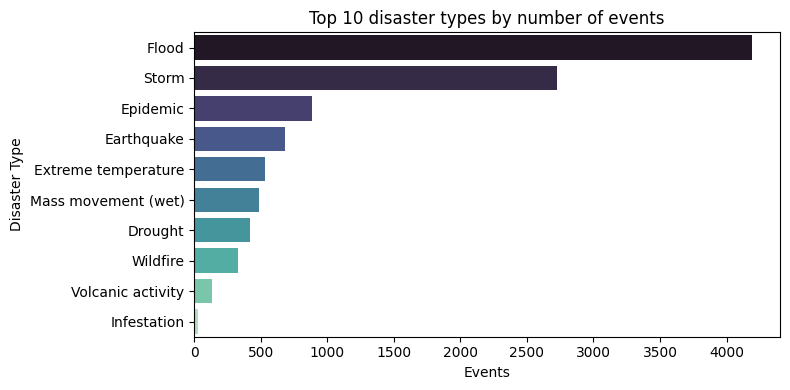

In [27]:
if 'Disaster Type' in emdat.columns:
    top_types = emdat['Disaster Type'].value_counts().head(10)
    plt.figure(figsize=(8,4))
    sns.barplot(x=top_types.values, y=top_types.index, orient='h',palette='mako')
    plt.title('Top 10 disaster types by number of events')
    plt.xlabel('Events')
    plt.ylabel('Disaster Type')
    plt.tight_layout()
    plt.show()

## 🗺️ 10. Global heat-map of cumulative deaths  
Interactive **choropleth** that shades each country by total recorded deaths.  
- Colour ramp: `Reds` (darker = higher toll).  
- Hover to see exact figures.  
- Margins trimmed for clean embedding in slides or dashboards.

In [13]:
agg = df.groupby('Country')['Deaths'].sum().reset_index()
fig = px.choropleth(
        agg,
        locations='Country',
        locationmode='country names',
        color='Deaths',
        color_continuous_scale='Reds',
        title='Cumulative deaths (2000-2005) by country'
)
fig.update_layout(margin=dict(l=0, r=0, t=40, b=0))
fig.show()

## 🌏 11. Disaster frequency by **UN region**  
Horizontal bar plot of the ten most frequently affected regions.  
- Uses the vibrant **viridis** palette for strong visual contrast.  
- Helps quickly spot regions with the highest **event density**

/tmp/ipykernel_278064/2367315958.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




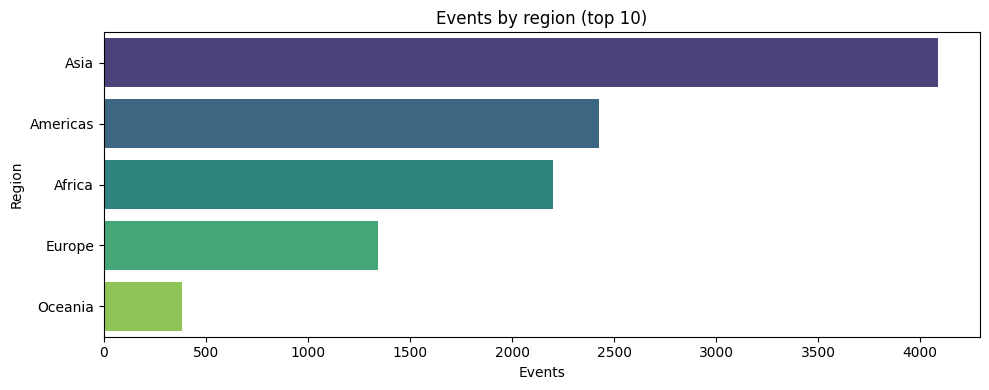

In [24]:
if 'Region' in emdat.columns:
    region_counts = emdat['Region'].value_counts().head(10)
    plt.figure(figsize=(10,4))
    sns.barplot(x=region_counts.values, y=region_counts.index, orient='h',palette='viridis')
    plt.title('Events by region (top 10)')
    plt.xlabel('Events')
    plt.ylabel('Region')
    plt.tight_layout()
    plt.show()

## 🌍 12. Top 10 Countries by Deaths and Economic Losses

Side-by-side bar plots comparing the ten countries with the highest fatalities and greatest economic losses.

- Top 10 countries by deaths are filtered using nlargest and sorted.
- Economic losses use a custom billion-dollar formatter for clarity.
- Visualized using seaborn with distinct color palettes: Reds_r for deaths and Blues_r for losses.
- Layout is neatly adjusted with tight_layout to prevent overlap.

/tmp/ipykernel_278064/3237454969.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_278064/3237454969.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




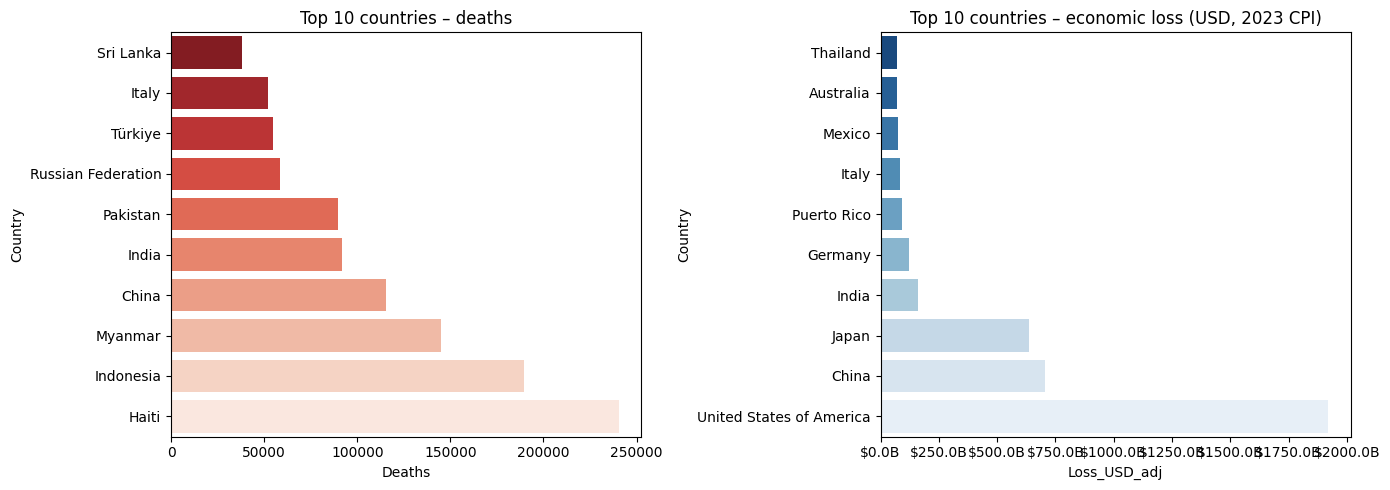

In [19]:
top_death = agg.nlargest(10, 'Deaths').sort_values('Deaths')
top_loss  = df.groupby('Country')['Loss_USD_adj'].sum().nlargest(10).reset_index().sort_values('Loss_USD_adj')

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(y='Country', x='Deaths', data=top_death, palette='Reds_r', ax=ax[0])
ax[0].set_title('Top 10 countries – deaths')

sns.barplot(y='Country', x='Loss_USD_adj', data=top_loss, palette='Blues_r', ax=ax[1])
ax[1].set_title('Top 10 countries – economic loss (USD, 2023 CPI)')
ax[1].xaxis.set_major_formatter(lambda x, pos: f'${x/1e9:.1f}B')

plt.tight_layout()

## 📊 13. Annual Human Impact Over Time

A line plot showing the annual human impact (Total Deaths and Total Affected) over time.

- Checks for the presence of relevant columns (Total Deaths and Total Affected).
- Groups data by year and computes annual human impact.
- Visualizes impact metrics using sns.lineplot on a logarithmic scale.
- Includes labels, legend, and dynamically adjusts layout for clarity.

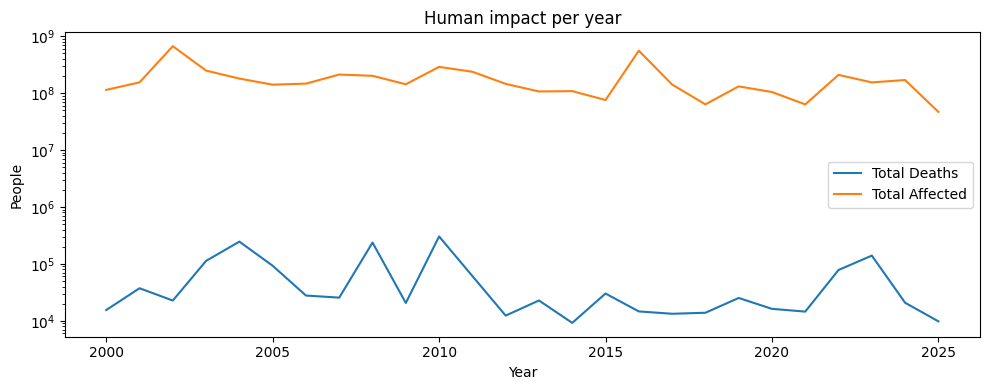

In [15]:
impact_to_plot = [c for c in ['Total Deaths','Total Affected'] if c in emdat.columns]
if len(impact_to_plot) > 0:
    annual_impact = emdat.groupby('Year')[impact_to_plot].sum(min_count=1).reset_index()
    plt.figure(figsize=(10,4))
    for c in impact_to_plot:
        sns.lineplot(data=annual_impact.sort_values('Year'), x='Year', y=c, label=c)
    plt.title('Human impact per year')
    plt.xlabel('Year')
    plt.ylabel('People')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

## 🌍 14. Top Countries by Total Affected Population
A horizontal bar plot of the top 15 countries with the highest cumulative affected population.

- Groups data by Country and sums the Total Affected values.
- Uses a logarithmic scale on the x-axis to visualize large data ranges.
- Sorted in descending order for clear comparison.
- Visualized using a horizontal bar layout for better label readability.

/tmp/ipykernel_278064/1803229783.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




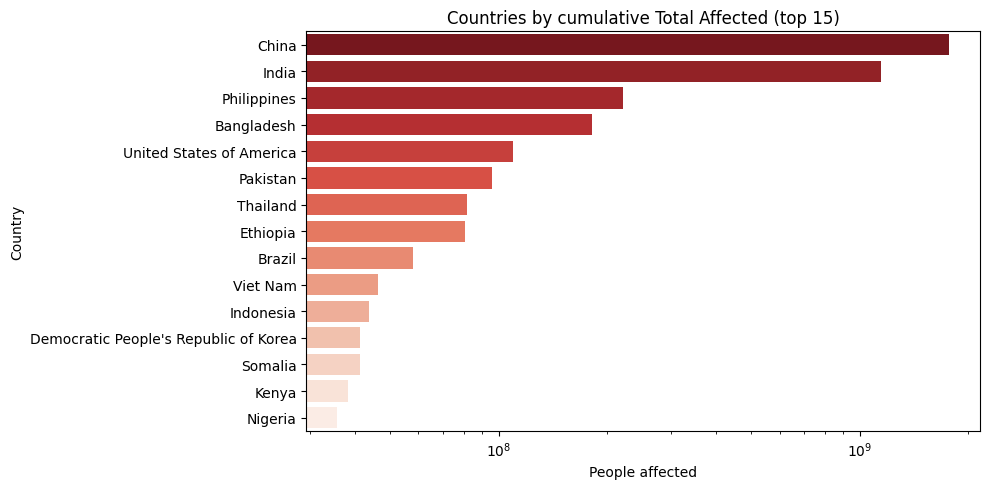

In [26]:
if 'Country' in emdat.columns and 'Total Affected' in emdat.columns:
    affected_by_country = emdat.groupby('Country')['Total Affected'].sum(min_count=1).sort_values(ascending=False).head(15)
    plt.figure(figsize=(10,5))
    sns.barplot(x=affected_by_country.values, y=affected_by_country.index, orient='h', palette='Reds_r')
    plt.title('Countries by cumulative Total Affected (top 15)')
    plt.xlabel('People affected')
    plt.ylabel('Country')
    plt.xscale('log')
    plt.tight_layout()
    plt.show()

## ⚠️ 15. Deaths Distribution by Disaster Type
A pie chart showing the proportion of total deaths across disaster types.

- Data is grouped by disaster type and sorted by total deaths.
- Visualized using Plotly for an interactive experience.

In [28]:
type_death = df.groupby('Disaster Type')['Deaths'].sum().sort_values(ascending=False)
fig = px.pie(names=type_death.index,
             values=type_death.values,
             title='Share of total deaths by disaster type')
fig.show()

## 💀 16. Top 10 Deadliest Disasters
A ranked list of the deadliest disaster events globally.

- Filters events with missing casualty data.
- Sorts by death count in descending order.
- Displays key details for clear comparison.
- Copy
- Retry
- Share


In [17]:
if 'Total Deaths' in emdat.columns and 'Event Name' in emdat.columns:
    deadliest = emdat[['Event Name','Country','Year','Total Deaths']].dropna(subset=['Total Deaths']).sort_values('Total Deaths', ascending=False).head(10)
    print('Top 10 deadliest events:')
    print(deadliest)

Top 10 deadliest events:
            Event Name                     Country  Year  Total Deaths
4366               NaN                       Haiti  2010      222570.0
2147               NaN                   Indonesia  2004      165708.0
3666  Cyclone 'Nargis'                     Myanmar  2008      138366.0
3670               NaN                       China  2008       87476.0
2525               NaN                    Pakistan  2005       73338.0
4576               NaN          Russian Federation  2010       55736.0
9409               NaN                     Türkiye  2023       53000.0
2150               NaN                   Sri Lanka  2004       35399.0
1718               NaN  Iran (Islamic Republic of)  2003       26796.0
1608               NaN                       Italy  2003       20089.0



## Save the filtered data to a CSV file

In [18]:
summary = {
    'records': [len(emdat)],
    'years_min': [int(emdat['Year'].min()) if emdat['Year'].notna().any() else np.nan],
    'years_max': [int(emdat['Year'].max()) if emdat['Year'].notna().any() else np.nan]
}
summary_df = pd.DataFrame(summary)
summary_path = 'emdat_summary_meta.csv'
summary_df.to_csv(summary_path, index=False)
print('Saved summary CSV to ' + summary_path)

Saved summary CSV to emdat_summary_meta.csv
